Hanh Tran

DSC630

Predict which “hotel cluster” the user is likely to book, given his (or her) search details:

For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.

The data set can be found at Kaggle: Expedia Hotel Recommendations. To get started, I would suggest exploring the file train.csv, which contains the logs of user behavior. There is another file named destinations.csv, which contains information related to hotel reviews made by users. There is a lot of data here, and making an accurate prediction is rather difficult, e.g., simply running a standard prediction algorithm will probably yield below 10% accuracy. Stary by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select. Then, split train.csv into a training and test set (feel free to select a smaller random subset of train.csv). Then, build at least two prediction models from the training set, and report the accuracies on the test set. As I mentioned, this is a difficult problem, so be creative with your solutions. You might want to try building your own predictor rather than a standard predictor model, e.g., a random forest. The purpose of this project is not necessarily to get great results but to understand the nuances and challenges of such problems.

In [146]:
#import libraries
import pandas as pd
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import datetime
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from datetime import datetime
%matplotlib inline

In [147]:
from sklearn.naive_bayes import GaussianNB

In [148]:
#use dask to read in large files
from dask import dataframe as dd
dask_df = dd.read_csv('train.csv')

In [149]:
dask_df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [150]:
dask_df.shape

(Delayed('int-4365a3f1-4600-483e-a5aa-ea72fb0ee0d3'), 24)

In [151]:
train_sample_df = dask_df.sample(frac=0.01, random_state=99)

In [152]:
train_sample_df.shape

(Delayed('int-9bd37c02-c0d1-4b63-9186-839495f2f04b'), 24)

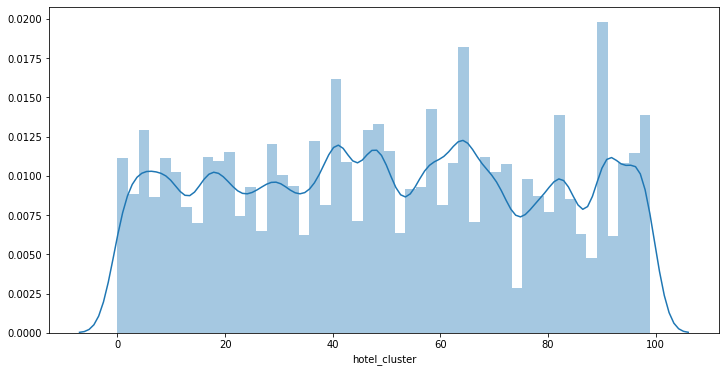

In [153]:
plt.figure(figsize=(12, 6))
sns.distplot(train_sample_df['hotel_cluster'])

In [258]:
#data to large to run, using sample size
sample_size_df = pd.read_csv('train.csv', nrows = 1800000).dropna()
destination = pd.read_csv('destinations.csv', nrows = 1800000)
sample_size_df= sample_size_df.sample(frac=0.20, random_state=99)
sample_size_df.shape

(227913, 24)

In [259]:
sample_size_df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
1442410,2013-09-19 16:56:13,2,3,66,174,18059,428.8010,1015427,0,0,...,0,1,12826,5,0,1,2,50,1230,77
1621150,2013-05-31 11:04:27,2,3,66,174,24103,7245.3229,325551,0,0,...,0,1,8242,1,0,2,3,171,61,97
170029,2013-03-26 15:54:20,2,3,66,321,47535,1313.1111,637665,0,1,...,0,1,8268,1,1,1,2,50,682,77
1621212,2014-01-30 18:40:36,2,3,66,174,24103,4.9627,325551,0,0,...,0,1,25470,6,0,2,2,50,365,86
1103616,2014-07-30 21:04:30,34,3,205,155,13951,108.7135,1184855,1,0,...,2,1,8281,1,0,1,2,50,663,98


Exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select. There are 100 Clusters

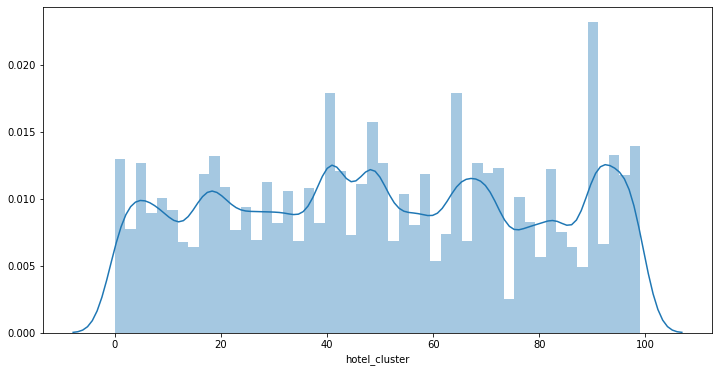

In [260]:
plt.figure(figsize=(12, 6))
sns.distplot(sample_size_df['hotel_cluster'])

In [261]:
#unable to read Date directly into model. create function to get month and year to feed into model
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

In [ ]:
def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

In [ ]:
#function to merge dataset
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [262]:
sample_size_df['date_time_year'] = pd.Series(sample_size_df['date_time'], index = sample_size_df.index)
sample_size_df['date_time_month'] = pd.Series(sample_size_df['date_time'], index = sample_size_df.index)
from datetime import datetime
sample_size_df.date_time_year = sample_size_df.date_time_year.apply(lambda x: get_year(x))
sample_size_df.date_time_month = sample_size_df.date_time_month.apply(lambda x: get_month(x))
del sample_size_df['date_time']

In [263]:
sample_size_df['date_time_year'].head()

1442410    2013
1621150    2013
170029     2013
1621212    2014
1103616    2014
Name: date_time_year, dtype: int64

In [264]:
sample_size_df['date_time_month'].head()

1442410    9
1621150    5
170029     3
1621212    1
1103616    7
Name: date_time_month, dtype: int64

In [265]:
sample_size_df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month
1442410,2,3,66,174,18059,428.8010,1015427,0,0,9,...,12826,5,0,1,2,50,1230,77,2013,9
1621150,2,3,66,174,24103,7245.3229,325551,0,0,9,...,8242,1,0,2,3,171,61,97,2013,5
170029,2,3,66,321,47535,1313.1111,637665,0,1,9,...,8268,1,1,1,2,50,682,77,2013,3
1621212,2,3,66,174,24103,4.9627,325551,0,0,9,...,25470,6,0,2,2,50,365,86,2014,1
1103616,34,3,205,155,13951,108.7135,1184855,1,0,9,...,8281,1,0,1,2,50,663,98,2014,7


In [266]:
sample_size_df['srch_ci_year'] = pd.Series(sample_size_df['srch_ci'], index=sample_size_df.index)
sample_size_df['srch_ci_month'] = pd.Series(sample_size_df['srch_ci'], index=sample_size_df.index)
# convert year & months to int
sample_size_df.srch_ci_year = sample_size_df.srch_ci_year.apply(lambda x: get_year(x))
sample_size_df.srch_ci_month = sample_size_df.srch_ci_month.apply(lambda x: get_month(x))
# remove the srch_ci column
del sample_size_df['srch_ci']

In [267]:
#check for correlation between variables
sample_size_df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.032824
is_booking                  -0.027094
site_name                   -0.026832
hotel_country               -0.025170
user_location_country       -0.020809
srch_destination_id         -0.013256
srch_rm_cnt                 -0.011781
hotel_continent             -0.003679
channel                     -0.002067
user_location_city          -0.000970
cnt                          0.001821
date_time_month              0.002023
srch_ci_month                0.002630
user_id                      0.002639
date_time_year               0.003025
is_mobile                    0.004373
srch_adults_cnt              0.005489
orig_destination_distance    0.008662
user_location_region         0.009251
srch_ci_year                 0.010751
srch_children_cnt            0.012462
posa_continent               0.014288
hotel_market                 0.019302
is_package                   0.044693
hotel_cluster                1.000000
Name: hotel_cluster, dtype: float64

In [268]:
pieces = [sample_size_df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
4                   7             246          30               0      1
                                               76               0      1
                                               81               0      1
                                               82               1      1
8                   50            416          7                0      2

In [269]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,4,7,246,30,0.0,0.250000,0.103448
1,4,7,246,76,0.0,0.250000,0.103448
2,4,7,246,81,0.0,0.250000,0.103448
3,4,7,246,82,1.0,0.250000,0.689655
4,8,50,416,7,0.0,0.068966,0.031746


In [270]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,4,7,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.031746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,150,2101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
sample_size_df = pd.merge(sample_size_df, destination, how='left', on='srch_destination_id')
sample_size_df = pd.merge(sample_size_df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
sample_size_df.fillna(0, inplace=True)
sample_size_df.shape

(227913, 275)

In [272]:
#concerned with booking only
sample_size_df = sample_size_df.loc[sample_size_df['is_booking'] == 1]

In [275]:
X = sample_size_df.drop(['user_id', 'hotel_cluster', 'is_booking', 'srch_co'], axis=1)
y = sample_size_df.hotel_cluster

In [276]:
X.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,90,91,92,93,94,95,96,97,98,99
2,2,3,66,321,47535,1313.1111,0,1,9,2,...,0.016591,0.022644,0.00553,0.002466,0.0,0.018833,0.030416,0.0,0.0,0.006203
13,2,3,66,442,28643,177.4020,0,0,1,4,...,0.000000,0.090000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
26,2,3,66,462,52482,3.2996,0,0,9,1,...,0.000000,0.100000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
34,2,3,66,260,19022,46.7991,0,0,9,2,...,0.000000,0.183746,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
36,2,3,66,174,43471,8747.5845,0,0,9,1,...,0.000000,0.000000,0.00000,0.008065,0.0,0.000000,0.000000,0.0,0.0,0.000000


As noted running a standard prediction algorithm will probably yield below 10% accuracy as in the case with Naive Bayes

In [277]:
#Naive Bayes
clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(clf, X, y, cv=10))

0.10239493373085953

In [215]:
from sklearn.neighbors import KNeighborsClassifier

In [216]:
#K-Nearest Neighbors Classifier
clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

0.267147202013076

K-Nearest Neighbors Classifier provided a bit better score at .267

In [217]:
#Random Forest Classifier
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273,max_depth=10,random_state=0))
np.mean(cross_val_score(clf, X, y, cv=10))

0.25790338820175185

Random Forest Classifier provided a score of .258

One of the main challenge concerns the date time value error as they needed to be converted to feed into model. Data conveyance also remains a challenge for higher accuracy that may require deeper feature engineering. 